# Tensor Parallelism in Haliax
In the [last tutorial](https://colab.research.google.com/drive/1QX4yH3zRFF3Xiibf1aahETcSQ5nbcUMz) we looked at how to do distributed training in [Haliax](https://github.com/stanford-crfm/haliax), including an implementation of FSDP.

Today, we're going to add [Tensor Parallelism](https://huggingface.co/transformers/v4.9.0/parallelism.html#tensor-parallelism) a la [Megatron](https://arxiv.org/abs/2104.04473).

Haliax (and Jax) make this easy. As with FSDP, we'll make no changes to our model code. This time, the only changes to our training loop will just be extracting a few variables.

The end result will be 5 lines of code. (You can skip to the TL;DR if you want!)

## Installation

Before diving in, we're going to do the obligatory ceremony where we install everything. You can skip this part.

In [ ]:
!pip install -U jax[cuda12]
!pip install -U "haliax>=1.4.dev322" equinox
# We use HF in this tutorial for tokenizers and data loading
!pip install transformers zstandard datasets

  Using cached zstandard-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0

## Environment Variable Hacking for Colab


(You can skip this part as well.)

Next up, we're going to detect if we're using a CPU, TPU, or GPU backend. If CPU, we're going to tell XLA to pretend it has 8 devices. If we're using CPU (or single GPU), nothing we do in this tutorial will actually make anything faster or save any memory. But, without emulating multiple devices, this tutorial won't make much sense.


In [ ]:
import os
from google.colab._serverextension._resource_monitor import get_gpu_stats


tpu_addr = os.environ.get('COLAB_TPU_ADDR', '')
if tpu_addr:
  _backend = "tpu"
elif len(get_gpu_stats()) > 0:
  _backend = "gpu"
else:
  _backend = "cpu"

if _backend == "cpu":
  print("Forcing 8 devices for cpu backend")
  os.environ["XLA_FLAGS"] = f"{os.environ.get('XLA_FLAGS', '')} --xla_force_host_platform_device_count=8"

del _backend, tpu_addr

Forcing 8 devices for cpu backend


In [ ]:
import jax
print(f"Using {len(jax.devices())} devices")

Using 8 devices


# The Model

Next, we're going to reproduce the model code, including the named axes, etc. from the original tutorial.

In [ ]:
import equinox as eqx
import haliax as hax
import haliax.nn as hnn
import jax
import jax.numpy as jnp

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

Layer = hax.Axis("layer", 4)
Head = hax.Axis("head", 8)
Key = hax.Axis("key", 16)
Embed = hax.Axis("embed", 32)
Mlp = hax.Axis("mlp", Embed.size * 4)

Batch = hax.Axis("batch", 8)
Pos = hax.Axis("position", 128)  # how long each sequence is
KPos = Pos.alias("key_position")
Vocab = hax.Axis("vocab", len(tokenizer))


class FeedForward(eqx.Module):
  # fields must be declared in Equinox
  proj_up: hnn.Linear
  proj_down: hnn.Linear

  @staticmethod
  def init(Embed, Intermediate, *, key):
    k_up, k_down = jax.random.split(key, 2)
    proj_up = hnn.Linear.init(Out=Intermediate, In=Embed, key=k_up)
    proj_down = hnn.Linear.init(Out=Embed, In=Intermediate, key=k_down)
    return FeedForward(proj_up, proj_down)

  def __call__(self, x):
    x = self.proj_up(x)
    x = hnn.gelu(x)
    return self.proj_down(x)


causal_mask = hax.arange(Pos) >= hax.arange(KPos).broadcast_axis(Pos)


def attention_scores(Key, KPos, query, key):
  # how similar is each query to each key
  scores = hax.dot(Key, query, key) / jnp.sqrt(Key.size)

  scores -= 1E9 * (1.0 - causal_mask)

  # convert to probabilities
  scores = hax.nn.softmax(scores, KPos)
  return scores


def attention(Key, KPos, query, key, value):
  scores = attention_scores(Key, KPos, query, key)
  answers = hax.dot(KPos, scores, value)

  return answers


class Attention(eqx.Module):
  proj_qkv: hnn.Linear  # input projection from [Embed] -> [(q, k, v), Head, Key]
  proj_answer: hnn.Linear  # output projection from [Head, Key] -> [Embed]

  @staticmethod
  def init(Embed, Head, Key, *, key):
    Qkv = hax.Axis("qkv", 3)  # create all three at once

    k_qkv, k_ans = jax.random.split(key, 2)
    proj_qkv = hnn.Linear.init(In=Embed, Out=(Qkv, Head, Key), key=k_qkv)
    proj_answer = hnn.Linear.init(In=(Head, Key), Out=Embed, key=k_ans)
    return Attention(proj_qkv, proj_answer)

  def __call__(self, x):
    qkv_out = self.proj_qkv(x)
    q, k, v = qkv_out.unbind("qkv")

    # Rename k and v's Pos as haliax doesn't support unnamed axes or duplicate axes
    k = k.rename({"position": "key_position"})
    v = v.rename({"position": "key_position"})

    answers = attention(Key, KPos, q, k, v)

    x = self.proj_answer(answers)
    return x


class Block(eqx.Module):
  ffn: FeedForward
  attention: Attention
  ln1: hnn.LayerNorm
  ln2: hnn.LayerNorm

  @staticmethod
  def init(key):
    k_ff, k_attn = jax.random.split(key, 2)
    ffn = FeedForward.init(Embed, Mlp, key=k_ff)
    attention = Attention.init(Embed, Head, Key, key=k_attn)
    ln1 = hnn.LayerNorm.init(Embed)
    ln2 = hnn.LayerNorm.init(Embed)
    return Block(ffn, attention, ln1, ln2)


  def __call__(self, x):
    x = x + self.ffn(self.ln1(x))
    x = x + self.attention(self.ln2(x))
    return x


class Transformer(eqx.Module):
  blocks: hnn.Stacked[Block]
  ln_f: hnn.LayerNorm

  @staticmethod
  def init(key):
    # vectorize the blocks
    blocks = hnn.Stacked.init(
       Layer, # The first argument is an Axis for how many layers we want in our Stacked
       Block,
       gradient_checkpointing=True,  # important for TPU with comparatively limited memory
    )( key=jax.random.split(key, Layer.size))
    ln_f = hnn.LayerNorm.init(Embed)
    return Transformer(blocks, ln_f)

  def __call__(self, x):
    x = self.blocks.fold(x)
    x = self.ln_f(x)
    return x


class Embeddings(eqx.Module):
  token_embeddings: hnn.Embedding
  position_embeddings: hnn.Embedding

  @staticmethod
  def init(key):
    k_wte, k_wpe = jax.random.split(key, 2)

    token_embeddings = hnn.Embedding.init(Vocab, Embed, key=k_wte)
    position_embeddings = hnn.Embedding.init(Pos, Embed, key=k_wpe)
    return Embeddings(token_embeddings, position_embeddings)

  def embed(self, input_ids):
    input_embeds = self.token_embeddings.embed(input_ids)
    position_embeds = self.position_embeddings.embed(hax.arange(Pos))

    return input_embeds + position_embeds

  def unembed(self, x):
    return self.token_embeddings.unembed(x)


class TransformerLm(eqx.Module):
  transformer: Transformer
  embeddings: Embeddings

  @staticmethod
  def init(key):
    k_t, k_embeddings = jax.random.split(key, 2)
    transformer = Transformer.init(key=k_t)
    embeddings = Embeddings.init(key=k_embeddings)
    return TransformerLm(transformer, embeddings)

  def __call__(self, input_ids):
    x = self.embeddings.embed(input_ids)
    x = self.transformer(x)
    lm_logits = self.embeddings.unembed(x)

    return lm_logits

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# The Original Training Harness

Here's our original simple training harness. As in the last tutorial, it has no bells and whistles for logging or anything like that. First, here's the data loader code. This data loader code is deliberately not that fancy or even good, but it is compact.

In [ ]:
import datasets

tokenizer.pad_token = "<pad>"

wikitext = datasets.load_dataset("dlwh/wikitext_103_detokenized", split="train", streaming=True)

def data_loop():
  batch = []
  for ex in wikitext:
    ids = tokenizer(ex["text"], padding=True, pad_to_multiple_of=Pos.size, return_tensors="np")
    ids = ids['input_ids'][0, 0:Pos.size]
    batch.append(ids)
    if len(batch) == Batch.size:
      batched_samples = hax.named(jnp.stack(batch), (Batch, Pos))
      yield batched_samples
      batch = []

  if len(batch) > 0:
    # make sure we have enough for our batch
    batch += [jnp.full(Pos.size, tokenizer.pad_token_id, dtype=jnp.int32)] * (Batch.size - len(batch))
    batched_samples = hax.named(jnp.stack(batch), (Batch, Pos))
    yield batched_samples


Next up, here's the loss function and model update function.

In [ ]:
# initialization
NUM_STEPS=100
model_key = jax.random.PRNGKey(0)

# we're going to use optax for the optimizer
import optax
optimizer = optax.adamw(1E-4, weight_decay=0.1)


def next_token_loss(pred_ids, true_ids):
  # need to roll the target tokens back by one so that each token is predicting the next token
  target_y = hax.roll(true_ids, -1, Pos)
  target_y = hnn.one_hot(target_y, Vocab)

  # we want to predict for each token except the last token (because we don't know whatit is)
  loss_mask = 1 - hnn.one_hot(-1, Pos, dtype=jnp.float32)

  loss = hnn.cross_entropy_loss(pred_ids, Vocab, target_y, where=loss_mask)

  return loss


def compute_loss(model, input_ids):
  pred_y = model(input_ids)
  loss = next_token_loss(pred_y, input_ids)
  # we have to return somethin that Jax recognizes as a scalar, which means a 0-dimensional array,
  # and not a named array
  return loss.scalar()

Next, we're going to use the same training loop we used for FSDP, except we'll modify it to accept axis mappings (rather than capturing global variables):

In [ ]:
@hax.named_jit
def init_model(axis_mapping):
  model = TransformerLm.init(key=model_key)
  return hax.shard_with_axis_mapping(model, axis_mapping)

import optax
optimizer = optax.adamw(1E-4, weight_decay=0.1)

# NEW
@hax.named_jit
def init_optimizer(model, param_axis_mapping):
  opt_state = optimizer.init(model)
  return hax.shard_with_axis_mapping(opt_state, param_axis_mapping)

@hax.named_jit
def train_step(model, opt_state, input_ids, compute_axis_mapping):
  grad_loss = eqx.filter_value_and_grad(compute_loss)

  with hax.axis_mapping(compute_axis_mapping):
    loss, grads = grad_loss(model, input_ids)

  updates, opt_state = optimizer.update(grads, opt_state, params=model)
  model = eqx.apply_updates(model, updates)

  return loss, model, opt_state

def training_loop(mesh, param_axis_mapping, compute_axis_mapping):
  with mesh:
    model = init_model(param_axis_mapping)
    import tqdm
    range_pbar = tqdm.tqdm(range(NUM_STEPS), desc="Training")

    opt_state = init_optimizer(model, param_axis_mapping)
    data_iter = data_loop()

    for i in range_pbar:
      input_ids = next(data_iter)
      input_ids = hax.shard_with_axis_mapping(input_ids, compute_axis_mapping)
      loss, model, opt_state = train_step(model, opt_state, input_ids, compute_axis_mapping)

      range_pbar.set_postfix(loss=loss.item())

      if i % 50 == 0:
        print(loss)

  return model

As a final step, we'll copy over the utilities we created for looking at device meshes:

In [ ]:
from jax.sharding import Mesh, NamedSharding, PartitionSpec
import numpy as onp

# quick little utility to visualize meshes themselves
# this piggybacks on a nice visualization in Jax.
def visualize_mesh(mesh):
  arr = jnp.zeros(mesh.devices.shape)
  arr = jax.device_put(arr, NamedSharding(mesh, PartitionSpec(*mesh.axis_names)))
  jax.debug.visualize_array_sharding(arr)

## Review: Sharding Data

Recall that the basic way we use a mesh is by mapping axes of our array to axes of the mesh. With that mapping in place, Jax will automatically distribute the array (and computations involving that array) across the mesh. Thus, to enable data parallelism, we just need to map our `Batch` axis of our `input_ids` array along the `"data"` axis of the mesh. Schematically, that looks like this:
![mesh showing `Batch` axis mapped to data axis](https://github.com/stanford-crfm/levanter/blob/main/docs/figures/data_parallel_mesh.png?raw=true)

In Haliax, we use a `dict` that we refer to as an **axis mapping** to handle this kind of assignment. Here's our data parallel axis mapping:

In [ ]:
dp_axis_mapping = {"batch": "data"}

We did FSDP by specifying another axis mapping, this one for storing parameters and optimizer states:

In [ ]:
fsdp_axis_mapping = {"embed": "data"}

# TL;DR: Tensor Parallelism in 5 lines of code

The TL;DR for this tutorial is that we'll do this for tensor parallelism:

In [ ]:
model_parallelism = 2
mp_mesh = Mesh(onp.array(jax.devices()).reshape(-1, model_parallelism), ("data", "model"))

tp_axis_mapping = {"mlp": "model", "head": "model"}
compute_axis_mapping = {**dp_axis_mapping, **tp_axis_mapping}
param_axis_mapping = {**fsdp_axis_mapping, **tp_axis_mapping}

The rest of the tutorial is why these are the right five lines of code.

# Tensor Parallelism

So far, we've looked at "plain old" data parallelism as well as FSDP. Both of these methods are basically the same, in that they fundamentally process one or more examples on a device at a time; you're not asking multiple devices to split up inference across more than one device at a time.

However, we can use multiple devices to process an example at a time, using so-called **model parallelism**. There are two kinds of model parallelism that people typically use. One is called Tensor Parallelism(TP) and the other called is Pipeline Parallelism (PP). (Hugging Face has a [good overview here](https://huggingface.co/transformers/v4.9.0/parallelism.html).)

Pipeline Parallelism is much more complex (and not currently implemented in Haliax), while Tensor Parallelism is actually quite straightforward, as you saw if looked at the TL;DR.

**Before continuing**, we emphasize that, in our experiments so far, TP provides no benefits on TPU for training up to at least 20B parameters. TP should provide benefits for decoding/serving, but right now we're focused on training.

## Tensor Parallelism, Conceptually

To get started, let's think about what we're trying to accomplish. We want to divide our computation so that we only do part (ideally $1/D$th, where $D$ is the number of devices) of the work on each device, communicating only what we have to.

The main work of a Transformer is made up of a bunch of matrix multiplications: the MLP has two matrix multiplications (`Embed -> Mlp`, `Mlp -> Embed`), and the attention block has both the projections (`Embed -> [Head, QKV, Key]`, `[Head, Key] -> Embed`) and the attention computation itself (which, recall, produces a tensor of shape `[Head, Pos, KeyPos]`).

The basic idea is we're going to turn each of those matrix multiplications into distributed matrix multiplies.

### Tensor Parallelism for an MLP, Conceptually

(This is the "hard way" to get to the eventual 3 lines of code, but I find it helpful.)

For instance, let's think about about our `FeedForward` module, which we'll reproduce here:

```python
class FeedForward(eqx.Module):
  proj_up: hnn.Linear
  proj_down: hnn.Linear

  @staticmethod
  def init(Embed, Intermediate, *, key):
    k_up, k_down = jax.random.split(key, 2)
    proj_up = hnn.Linear.init(Out=Intermediate, In=Embed, key=k_up)
    proj_down = hnn.Linear.init(Out=Embed, In=Intermediate, key=k_down)
    return FeedForward(proj_up, proj_down)

  def __call__(self, x):
    x = self.proj_up(x)
    x = hnn.gelu(x)
    return self.proj_down(x)
```

What we'd like to do, conceptually, is do something like:

1. change `proj_up` so that each device computes only `Intermediate.size/D` of the entries.
2. compute `gelu` on just those entries
3. change `proj_down` so that each device computes a (per-position) vector of size `Embed` and then combine the results into a single `Embed` vector.

Naïvely, this might look something like:

```python
########################
# NOT REAL HALIAX CODE #
########################
class TensorParallelFeedForward(eqx.Module):
  proj_up: hnn.Linear
  proj_down: hnn.Linear

  @staticmethod
  def init(Embed, Intermediate, *, key):

    k_up, k_down = jax.random.split(key, 2)
    # NEW
    LocalIntermdiate = Axis("local_intermediate", Intermediate.size/NUM_DEVICES)
    proj_up = hnn.Linear.init(Out=LocalIntermediate, In=Embed, key=k_up)
    proj_down = hnn.Linear.init(Out=Embed, In=LocalIntermediate, key=k_down)

    return FeedForward(proj_up, proj_down)

  def __call__(self, x):
    # this is the same, just renamed a bit
    local_x = self.proj_up(x)
    local_x = hnn.gelu(local_x)
    local_x = self.proj_down(local_x)
    # NEW
    x = distributed_add(local_x)
    return x
```

Note, `distributed_add` isn't a real function. People who used JAX some time ago might recognize `distributed_add` as `psum`, and indeed, it basically is. People who have written tensor parallel PyTorch might recognize the last two bit of `__call__` as [`ColumnParallelLinear`](https://github.com/facebookresearch/metaseq/blob/main/metaseq/modules/megatron/mpu/layers.py#L386) and the first couple of lines as `RowParallelLinear`.

Conceptually, this is exactly what we want (for `FeedForward`), but the way we get it in Haliax is even easier.

## Tensor Parallelism with Haliax and Mesh Parallelism

Here's the actual `FeedForward` code we'll be using:

```python
class FeedForward(eqx.Module):
  proj_up: hnn.Linear
  proj_down: hnn.Linear

  @staticmethod
  def init(Embed, Intermediate, *, key):
    k_up, k_down = jax.random.split(key, 2)
    proj_up = hnn.Linear.init(Out=Intermediate, In=Embed, key=k_up)
    proj_down = hnn.Linear.init(Out=Embed, In=Intermediate, key=k_down)
    return FeedForward(proj_up, proj_down)

  def __call__(self, x):
    x = self.proj_up(x)
    x = hnn.gelu(x)
    return self.proj_down(x)
```

This is in fact exactly the feed forward code we started with, with no changes at all.

So how do we get model parallelism? Instead, what we're going to do is tell Haliax (and for it to tell JAX) to partition the `Intermediate`/`Mlp` axis, in the exact same way we told it to partition the `Batch`) axis. The only difference is that we're going to need to change our `Mesh` to have *two* axes instead of *one*. One called `"data"` and the other called `"model"` (for "model parallelism"). Once we partition our model's parameters correctly, JAX/XLA will take care of the distributed communication, just as it did with FSDP.

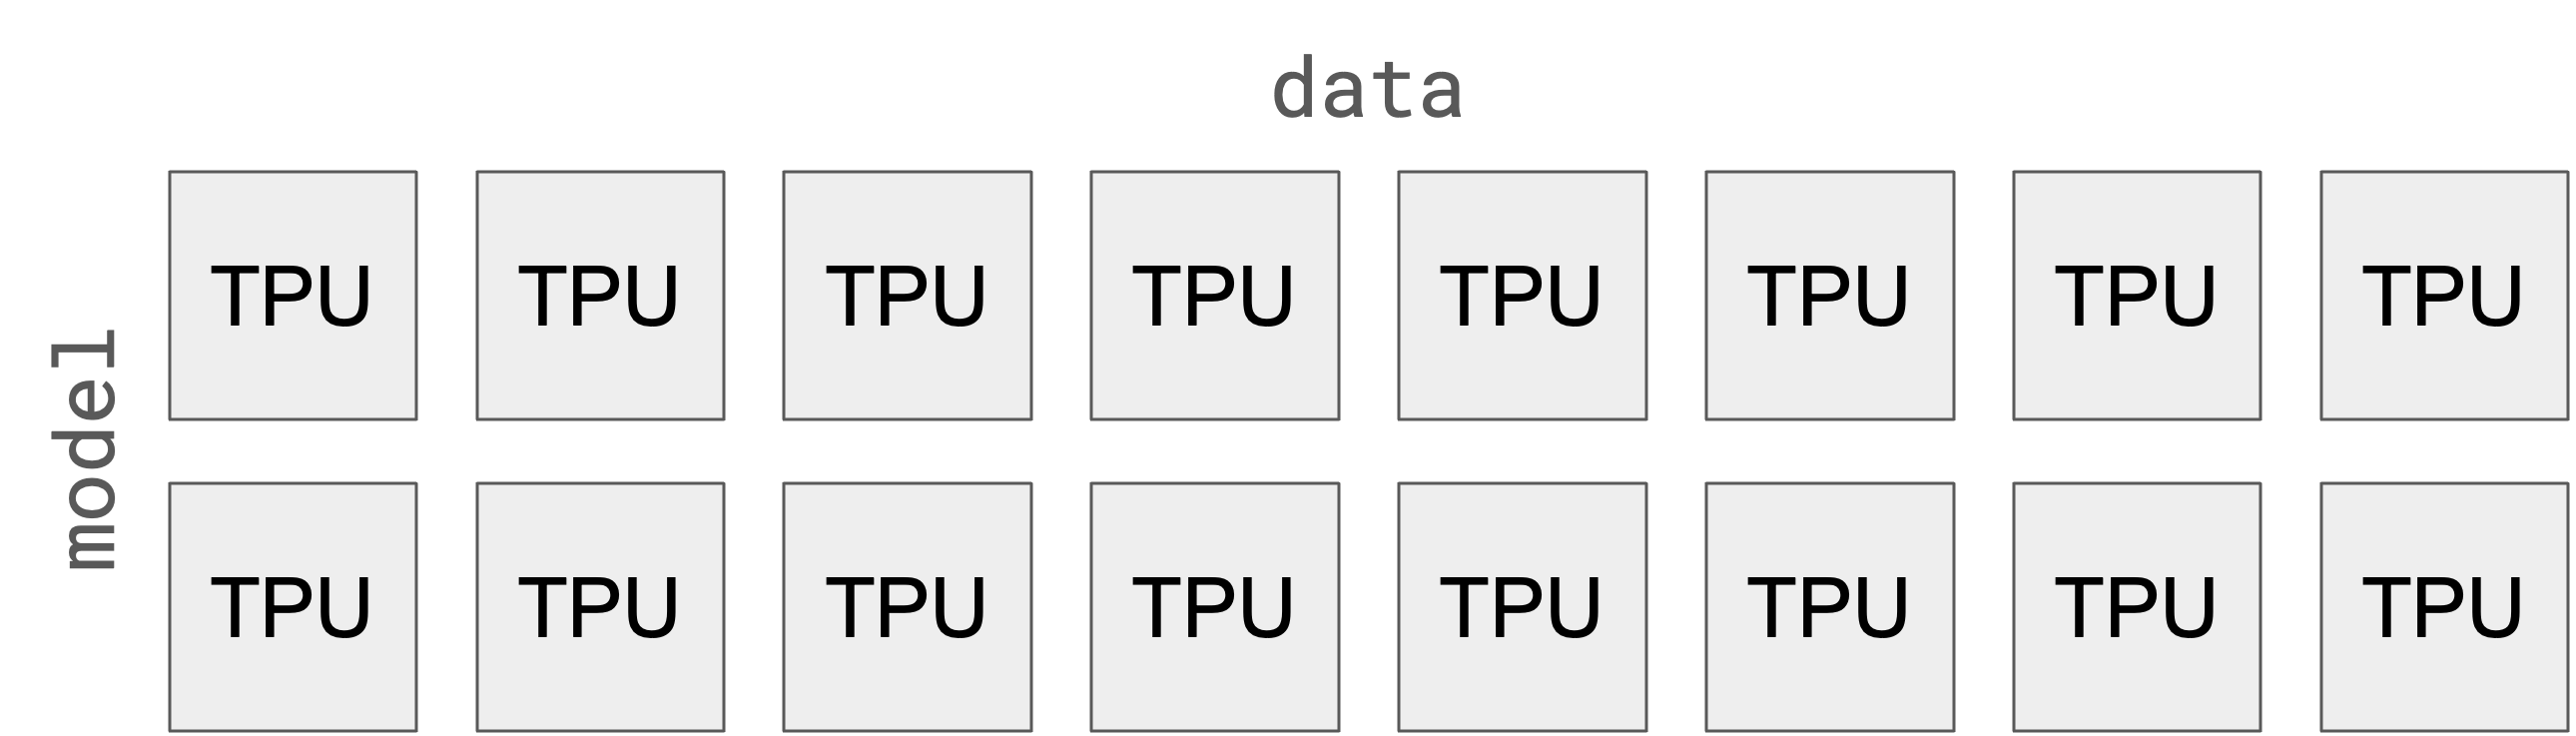

In [ ]:
model_parallelism = 2
mp_mesh = Mesh(onp.array(jax.devices()).reshape(-1, model_parallelism), ("data", "model"))

# in the Jax visualization, rows will be "data" and columns "model"
visualize_mesh(mp_mesh)

                  
  CPU 0    CPU 1  
                  
                  
  CPU 2    CPU 3  
                  
                  
  CPU 4    CPU 5  
                  
                  
  CPU 6    CPU 7  
                  

Next, we'll tell Haliax to map the `Mlp` axis to the `model` axis:

In [ ]:
compute_axis_mapping = {"batch": "data", "mlp": "model"}
param_axis_mapping = {"embed": "data", "mlp": "model"}

Now let's try our simple `FeedForward` after partitioning it:

In [ ]:
ff = FeedForward.init(Embed, Mlp, key=jax.random.PRNGKey(0))

# we'll use compute_axis_mapping because we're going to do compute on it.
ff = hax.shard_with_axis_mapping(ff, compute_axis_mapping, mp_mesh)
x = hax.random.uniform(jax.random.PRNGKey(1), (Batch, Embed))
x = hax.shard_with_axis_mapping(x, compute_axis_mapping, mp_mesh)

print("input array sharding")
jax.debug.visualize_array_sharding(x.array)

intermediate = ff.proj_up(x)
print("`intermediate` array sharding:")
print(intermediate.axes)
jax.debug.visualize_array_sharding(intermediate.array)
# just for completeness:
intermediate = hax.nn.gelu(intermediate)
out = ff.proj_down(intermediate)
print("output array sharding:")
jax.debug.visualize_array_sharding(out.array)


input array sharding


                                                                                
                                    CPU 0,1                                     
                                                                                
                                                                                
                                    CPU 2,3                                     
                                                                                
                                                                                
                                    CPU 4,5                                     
                                                                                
                                                                                
                                    CPU 6,7                                     
                                                                                

`intermediate` array sharding:
(Axis(name='batch', size=8), Axis(name='mlp', size=128))


output array sharding:


                                                                                
                                    CPU 0,1                                     
                                                                                
                                                                                
                                    CPU 2,3                                     
                                                                                
                                                                                
                                    CPU 4,5                                     
                                                                                
                                                                                
                                    CPU 6,7                                     
                                                                                

As you can see, the `intermediate` array is indeed sharded so that the first axis, `Batch`, is sharded across the `"data"` axis of the mesh, while the second axis, `Mlp`, is sharded across the `"model"` axis of the mesh.

And, as desired, the inputs and outputs are sharded the same way.

## Tensor-Parallel Attention

Let's do tensor parallel attention. I'm not going to go into too much depth here, but it's actually straightforward with the tools we have arleady.

Recall that the transformations we do in the Attention module are:
* `proj_qkv`: `[Embed] -> [Qkv, Head, Key]`
* Attention: `(q: [Head, Pos, Key], k: [Head, KeyPos, Key], v: [Head, KeyPos, Key] -> [Head, Pos, Key]`)
* `proj_answer`: `[Head, Key] -> Embed`

Note that all of these operations involve a `Head` dimension. And indeed, intuitively, it makes sense that each head of multi-headed attention can mostly be done independently, modulo the final projection back to `Embed`.

So, to make tensor parallel attention, we just need to partition `Head` just like we did `Mlp`.

This gets us back to our TL;DR axis mappings:



In [ ]:
tp_mapping = {"mlp": "model", "head": "model"}
compute_axis_mapping = {**dp_axis_mapping, **tp_mapping}
param_axis_mapping = {**fsdp_axis_mapping, **tp_mapping}

And finally, let's run it. As before, with a model this size and especially on CPU, it's not going to make anything faster, and it'll probably be a bit slower.

In [ ]:
_ = training_loop(mp_mesh, param_axis_mapping, compute_axis_mapping)

Training:   1%|          | 1/100 [00:06<11:11,  6.78s/it, loss=10.9]

10.933688


Training:  51%|█████     | 51/100 [03:17<03:57,  4.84s/it, loss=8.8]

8.8004675


Training: 100%|██████████| 100/100 [05:38<00:00,  3.38s/it, loss=8.79]


# Conclusion

That's it! Short and sweet. You have the tools you need to implement tensor parallelism in Haliax!